In [60]:
import matplotlib as mpl
import mplhep
%matplotlib inline
mpl.style.use(mplhep.style.ROOT)
import matplotlib.pyplot as plt

def title_bar(text=None, *, by_ldmx='Internal', exp_text_kw = dict(), lumitext_kw = dict(), **kwargs):
    mplhep.label.exp_text('LDMX', by_ldmx, **exp_text_kw, **kwargs)
    if text is not None:
        mplhep.label.lumitext(text, **lumitext_kw, **kwargs)

import hist
import upldmx
import awkward as ak
import numpy as np

In [61]:
events = upldmx.arrays()

In [62]:
tot_eot = ak.count(events.weight)/ak.sum(events.weight)*20*1e6
per_day = 1e12/tot_eot

1. Muon scattering angle
2. Muon pair opening angle
3. Muon-contributed sim hits in first layer

# Sim Particles

In [150]:
muons = events.SimParticles[abs(events.SimParticles.pdgID)==13]

(array([1.31385e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 6.00000e+00]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 10 artists>)

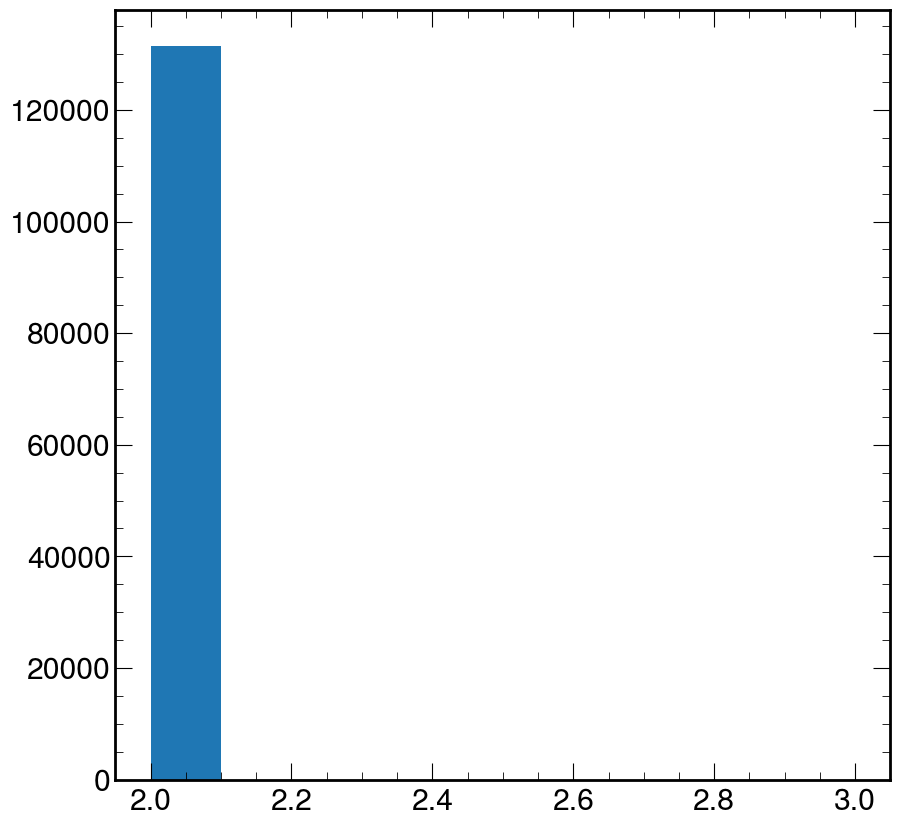

In [151]:
plt.hist(ak.count(muons.genStatus, axis=-1))

In [152]:
angles = (
    hist.Hist.new
    .Reg(100,0,np.pi/3,label='Muon Scattering Angle [rad]')
    .Reg(100,0,np.pi/2,label='Pair Opening Angle [rad]')
    .Double()
)
angles.fill(
    *[ak.flatten(a)
      for a in ak.broadcast_arrays(
          muons.momentum.theta,
          muons[:,0].momentum.deltaangle(muons[:,1].momentum)
      )
     ]
)

Hist(
  Regular(100, 0, 1.0472, label='Muon Scattering Angle [rad]'),
  Regular(100, 0, 1.5708, label='Pair Opening Angle [rad]'),
  storage=Double()) # Sum: 262701.0 (262788.0 with flow)

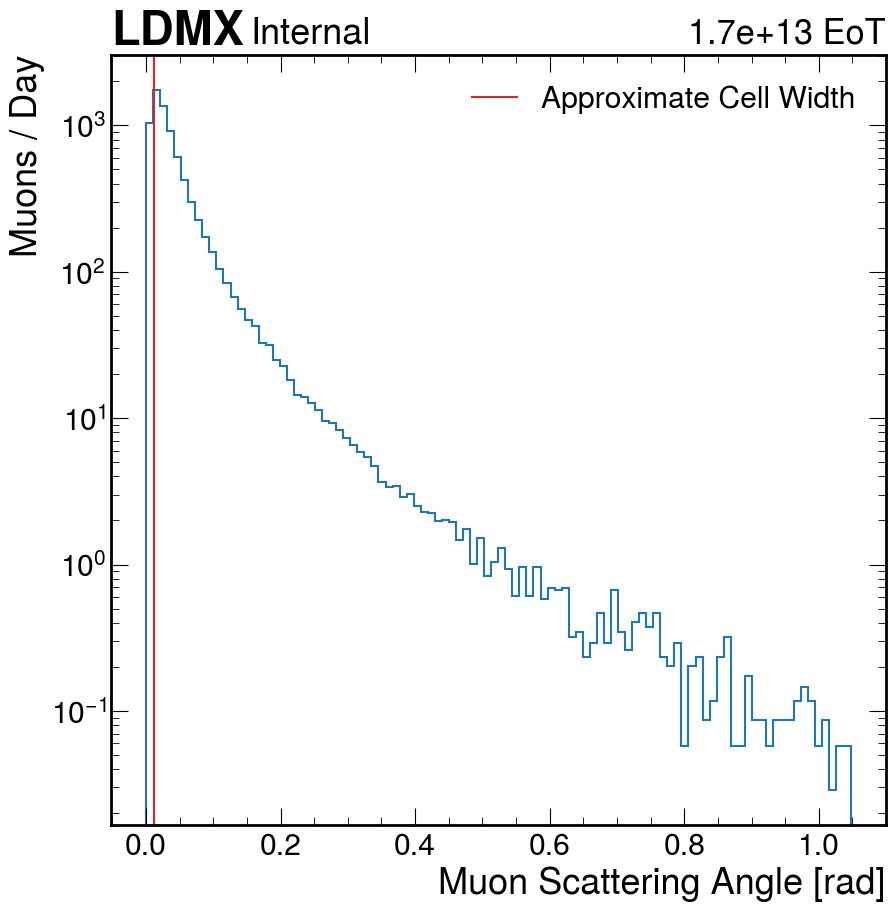

In [161]:
(angles[:,sum]*per_day/2).plot(flow='none')
plt.axvline(3/240, label='Approximate Cell Width', color='tab:red')
plt.legend()
plt.ylabel('Muons / Day')
title_bar(f'{tot_eot:.1e} EoT')
plt.yscale('log')
plt.savefig('plots/muon-scattering-angle.png', bbox_inches='tight')
plt.show()

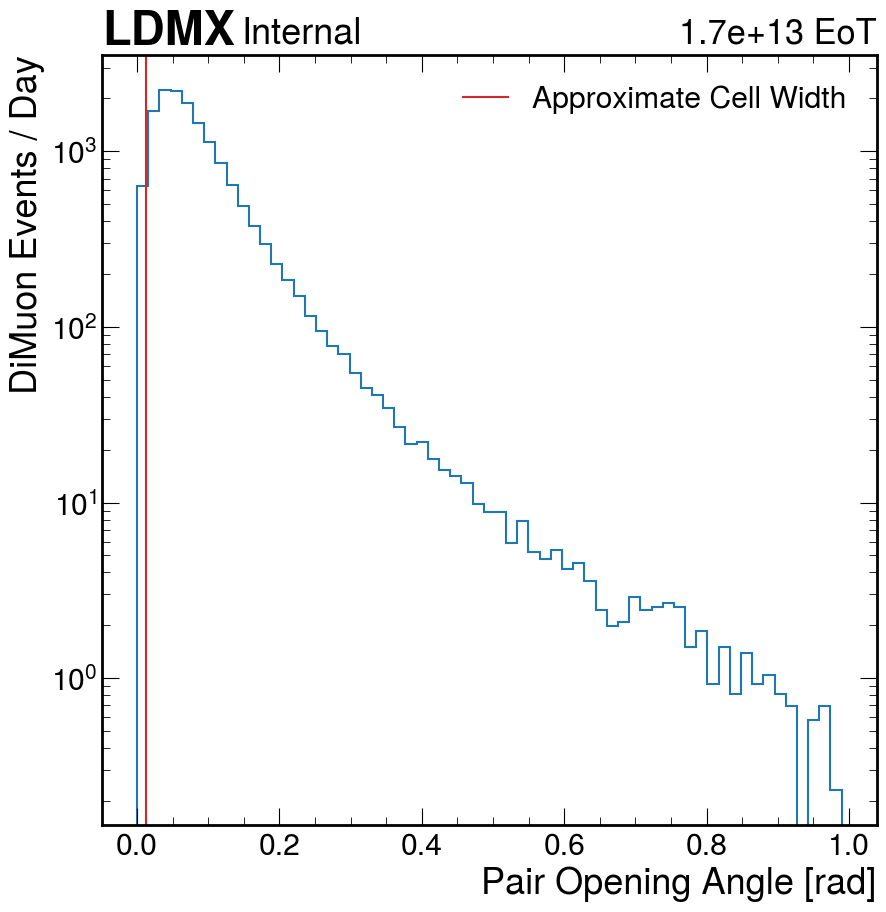

In [160]:
(angles[sum,:hist.loc(1)]*per_day).plot(flow='none')
title_bar(f'{tot_eot:.1e} EoT')
plt.yscale('log')
plt.axvline(
    3/240,
    label='Approximate Cell Width',
    color='tab:red'
)
plt.legend()
plt.ylabel('DiMuon Events / Day')
plt.savefig('plots/muon-opening-angle.png',bbox_inches='tight')
plt.show()

# Sim Hits

In [70]:
hits = events.EcalSimHits[events.EcalSimHits.layer==0]

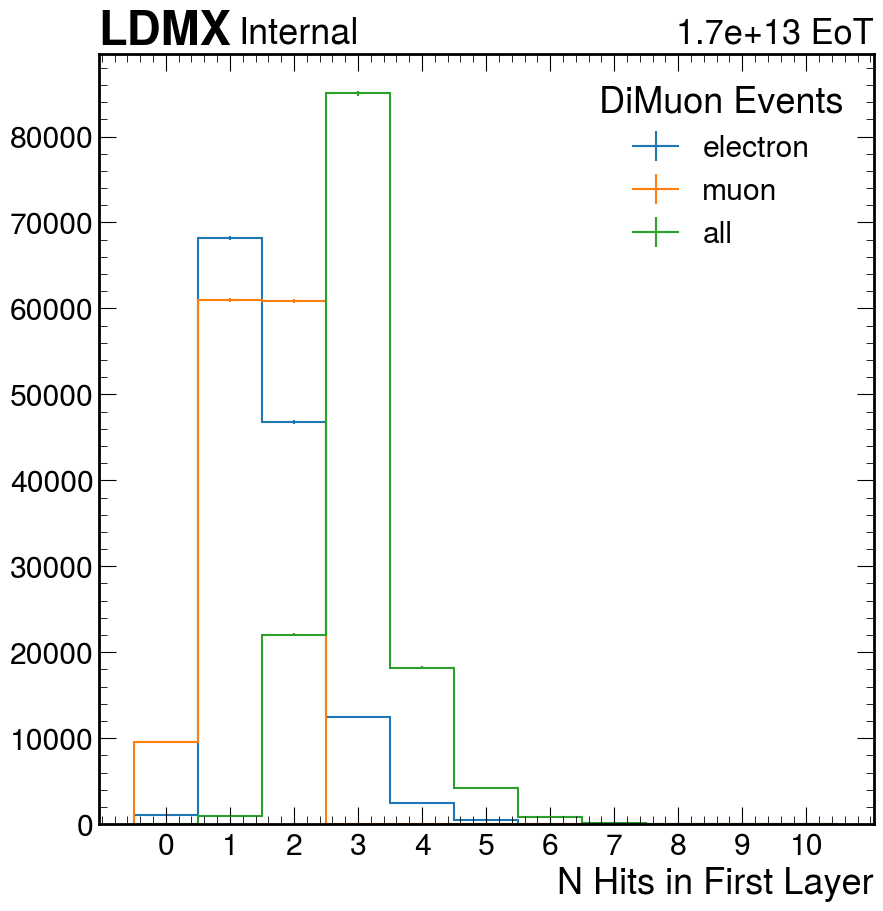

In [74]:
h = (
    hist.Hist.new
    .Integer(0,11,label='N Hits in First Layer')
    .StrCategory(['electron','muon','all'])
    .Double()
)
h.fill(
    ak.sum(hits.has_contrib(11), axis=-1),
    'electron'
)
h.fill(
    ak.sum(hits.has_contrib(13)|hits.has_contrib(-13), axis=-1),
    'muon'
)
h.fill(
    ak.count(hits.id, axis=-1),
    'all'
)
h.plot(overlay=True)
plt.legend(title='DiMuon Events')
title_bar(f'{tot_eot:.1e} EoT')
plt.show()

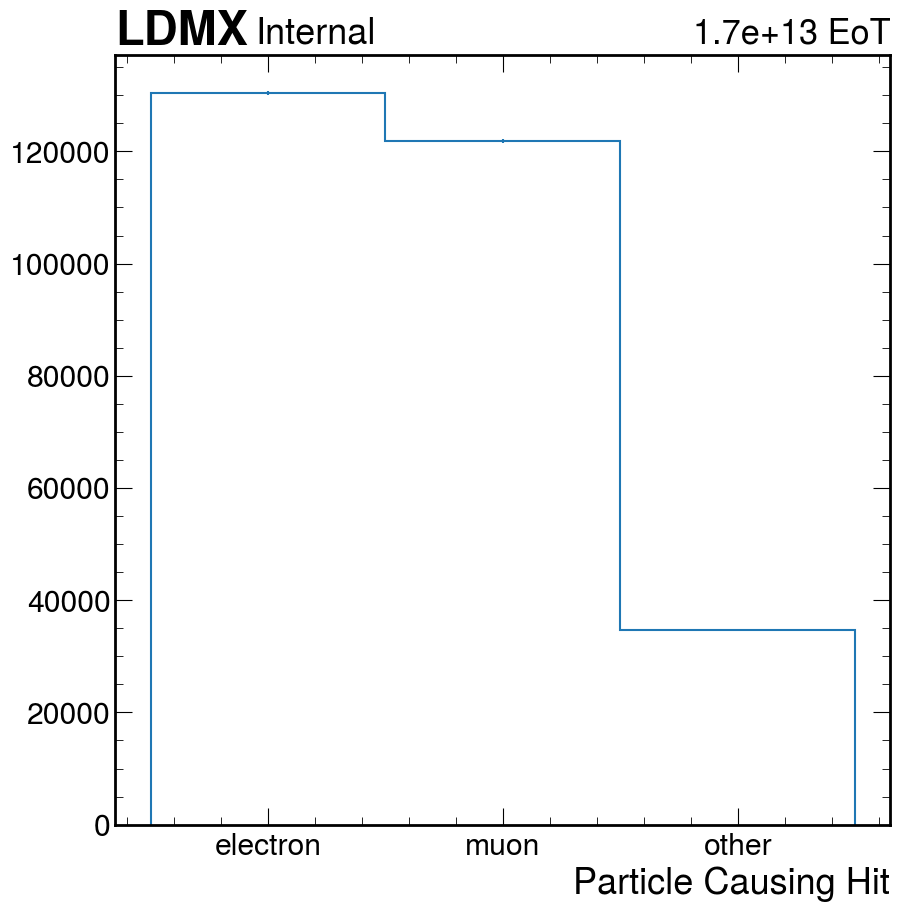

In [124]:
def highest_hit(selection):
    sl = hits[selection]
    return ak.drop_none(ak.firsts(sl[ak.argsort(sl.edep)]))

high_hit = (
    hist.Hist.new
    .IntCategory([], growth=True, name='cellid')
    .StrCategory(['electron','muon','other'], name='cause', label='Particle Causing Hit')
    .Double()
)
high_hit.fill(
    cellid = highest_hit(hits.has_contrib(13)|hits.has_contrib(-13)).id,
    cause='muon'
)
high_hit.fill(
    cellid = highest_hit(hits.has_contrib(11)).id,
    cause = 'electron'
)
high_hit.fill(
    cellid = highest_hit(~(hits.has_contrib(13)|hits.has_contrib(-13)|hits.has_contrib(11))).id,
    cause = 'other'
)
high_hit[sum,:].plot()
title_bar(f'{tot_eot:.1e} EoT')
plt.show()

In [114]:
# define a lookup table (LUT) for hit IDs to transverse cell centers
# this only needs to be redefined if the `hits` array changes because there might
# be an ID in the new selection that wasn't in the old
sorted_by_id = ak.flatten(hits)[ak.argsort(ak.flatten(hits).id)]
id_to_pos_lut = {
    hit.id : (hit.pos.x, hit.pos.y)
    for hit in ak.drop_none(ak.firsts(ak.unflatten(sorted_by_id, ak.run_lengths(sorted_by_id.id))))
}

def to_cell_center(ids):
    return np.vectorize(id_to_pos_lut.get)(ids)

In [125]:
# convert the array of IDs stored in the histogram to the array of cell centers
# this needs to be done for each histogram because the lookup depends on the _order_
cell_centers = to_cell_center(high_hit.axes[0])

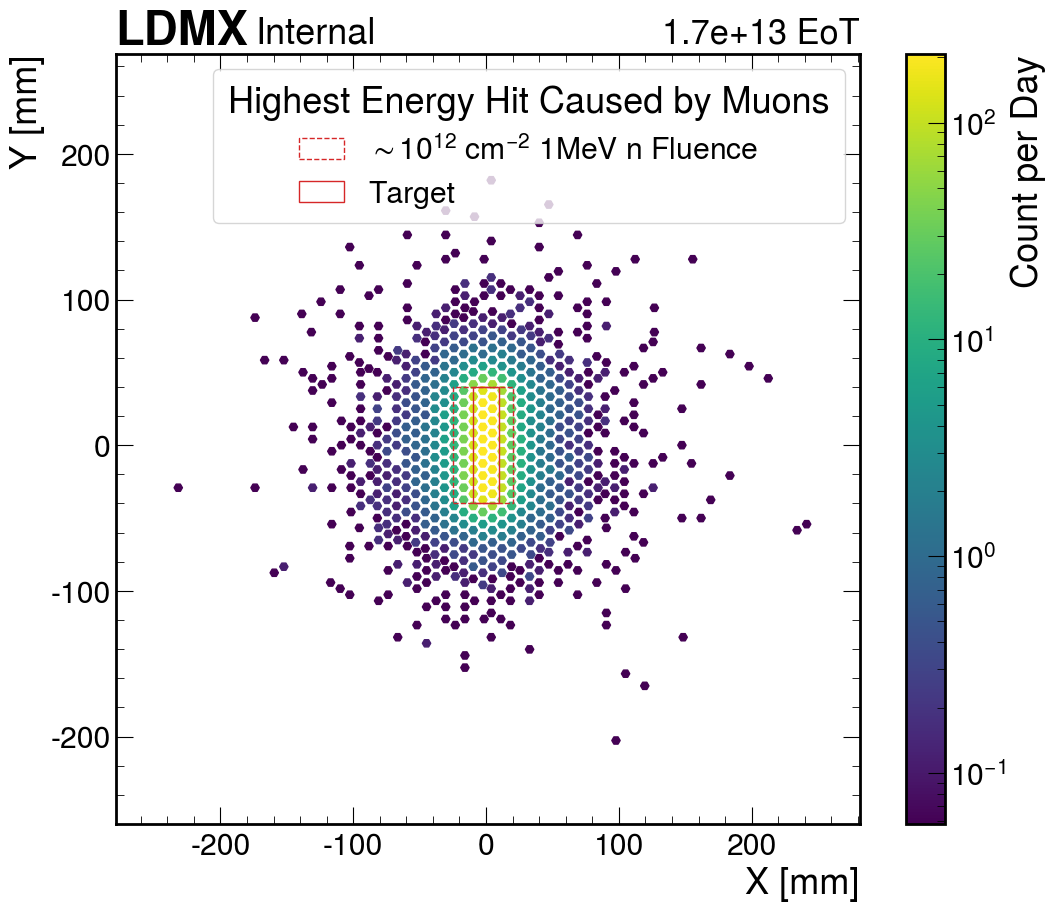

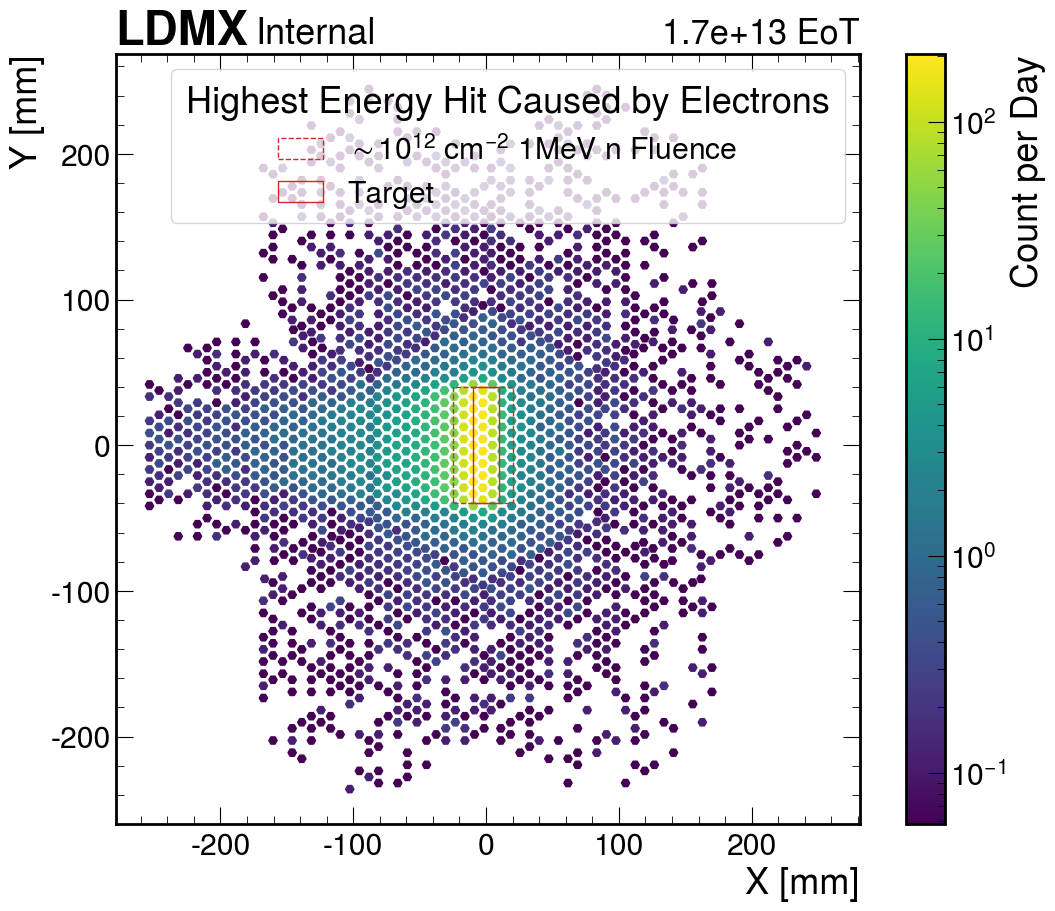

In [148]:
def draw_boxes():
    boxes = [
        mpl.patches.Rectangle((-25,-40),45,80,facecolor='none',edgecolor='tab:red',linestyle='--',label='$\\sim10^{12}$ cm$^{-2}$ 1MeV n Fluence'),
        mpl.patches.Rectangle((-10,-40),20,80,facecolor='none',edgecolor='tab:red',linestyle='-',label='Target')
    ]
    for b in boxes:
        plt.gca().add_patch(b)

plt.figure(figsize=(12,10))
plt.scatter(
    cell_centers[0], cell_centers[1],
    c = high_hit[:,'muon'].values()*per_day,
    marker='H',
    norm='log',
    # vmax=1000
)
plt.colorbar(label='Count per Day')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
# plt.text(-260,255,'Highest Energy Hit Caused by Muons',ha='left',va='top',size='small')
title_bar(f'{tot_eot:.1e} EoT')
draw_boxes()
plt.legend(title='Highest Energy Hit Caused by Muons', frameon=True)
plt.savefig('plots/highest-energy-muon-hit-xy.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,10))
plt.scatter(
    cell_centers[0], cell_centers[1],
    c = high_hit[:,'electron'].values()*per_day,
    marker='H',
    norm='log',
    # vmax=1000
)
plt.colorbar(label='Count per Day')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
# plt.text(-260,255,'Highest Energy Hit Caused by Electrons',ha='left',va='top',size='small')
title_bar(f'{tot_eot:.1e} EoT')
draw_boxes()
plt.legend(title='Highest Energy Hit Caused by Electrons', frameon=True)
plt.savefig('plots/highest-energy-electron-hit-xy.png', bbox_inches='tight')
plt.show()

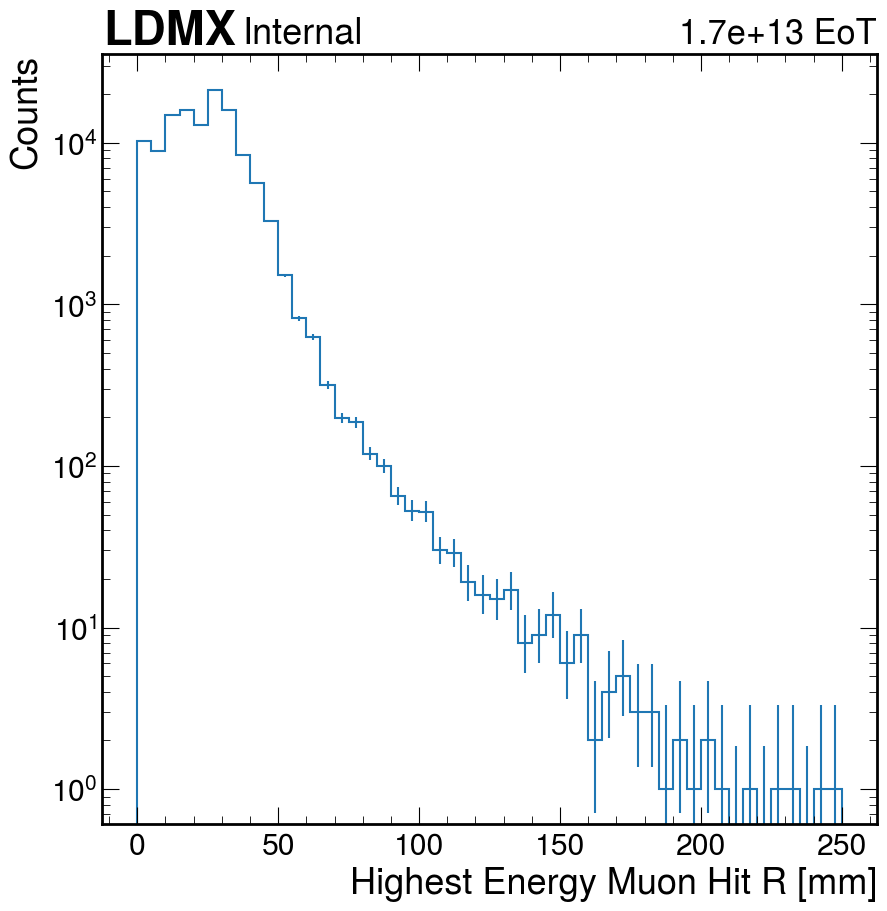

In [163]:
fig, ax = plt.subplots()
(
    hist.Hist.new
    .Reg(50,0,250,name='Highest Energy Muon Hit R [mm]')
    .Double()
).fill(
    highest_hit(hits.has_contrib(13)|hits.has_contrib(-13)).pos.rho
).plot()
ax.set_ylabel('Counts')
ax.set_yscale('log')
# ax.text(
#     0.95,0.95,
#     'Highest Energy Hit\nCaused by Muons',
#     ha='right',
#     va='top',
#     size='small',
#     transform=ax.transAxes
# )
title_bar(f'{tot_eot:.1e} EoT', ax=ax)
fig.savefig('plots/highest-energy-muon-hit-rho.png', bbox_inches='tight')
plt.show()